# Project of COMP7015

Welcome to the Project of COMP7015! 

This project consists of two parts, i.e., Part 1: Simple Classification with Neural Network & Part 2: Adversarial Examples for Neural Networks. Through trying this project, you are expected to have a brief understanding on the image classification and the special vulnerability of Neural Networks induced by adversarial examples.

## Part 1: Simple Classification with Neural Network

In this part, you will implement a simple neural network to classify grayscale images of handwritten digits (0 - 9) from the MNIST dataset (in the attachment, i.e., ```images_train.npy/images_test.npy/labels_train.npy/labels_test.npy```). The dataset contains 60,000 training images and 10,000 testing images of handwritten digits. Each image is 28×28 pixels in size, and is generally represented as a flat vector of 784 numbers. It also includes labels for each example, a number indicating the actual digit (0 - 9) handwritten in that image. 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

(a) **[5 points]** Please realize an util function: <em>one_hot_labels</em>.

In the implementation of the cross entropy loss, it is much convenient if numerical labels are transformed into one-hot labels. For example, numerical label 5 -> one-hot label [0,0,0,0,0,1,0,0,0,0]. Accordingly, the cross entropy loss can be written as follow:

$CE(y,\hat y)=-\sum_{k=1}^K y_k \log \hat y_k$,

where $\hat y$ is the softmax outputs from the model for the training example, $y$ is the one-hot (ground-truth) label, and the subscript refers to the element of $y$ at the coordinate $k$. 

In [2]:
def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    ### YOUR CODE HERE
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    ### END YOUR CODE
    return one_hot_labels


To begin with, MNIST dataset is loaded from the following files:

    images_train.npy: 60k images with normalized features, the dimension of image features is 784.
    images_test.npy
    labels_train.npy: corresponding numerical labels (0-9).
    labels_test.npy
    
Note that, the original training images and labels are separated into a set of 50k data for training and 10k data for validation. 

In [3]:
def readData(images_file, labels_file):
    x = np.load(images_file)
    y = np.load(labels_file)
    return x, y

def prepare_data():

    trainData, trainLabels = readData('images_train.npy', 'labels_train.npy')
    trainLabels = one_hot_labels(trainLabels)
    p = np.random.permutation(60000)
    trainData = trainData[p,:]
    trainLabels = trainLabels[p,:]
    valData = trainData[0:10000,:]
    valLabels = trainLabels[0:10000,:]
    trainData = trainData[10000:,:]
    trainLabels = trainLabels[10000:,:]
    testData, testLabels = readData('images_test.npy', 'labels_test.npy')
    testLabels = one_hot_labels(testLabels)
    return trainData, trainLabels, valData, valLabels, testData, testLabels
# load data for train, validation, and test.
trainData, trainLabels, devData, devLabels, testData, testLabels = prepare_data()


(b) **[5 points]** Please realize the softmax function as well as the sigmoid function: <em>softmax(x)</em> and <em>sigmoid(x)</em>.

The $k$-th element of softmax is calculated via:

$softmax(x)_k=\frac {e^{x_k}}{\sum_j e^{x_j}}=\frac {e^{x_k+c}}{\sum_j e^{x_j+c}}$

The last equation holds since adding a constant won't change softmax results. Note that, you may encounter an overflow when softmax computes the exponential, so please using the 'max' tricks to avoid this problem.  

The sigmoid is calculated by:

$sigmoid(x)=\frac {1}{1+e^{-x}} = \frac {e^x}{e^x + 1}$

For numerical stability, please use the 1st equation for positive inputs, and the 2nd equation for negative inputs. 

In [4]:
def softmax(x):
    """
    x is of shape: batch_size * #class
    """
    ### YOUR CODE HERE
    c = np.max(x, axis=1, keepdims=True)
    numerator = np.exp(x - c)
    denominator = np.sum(numerator, axis=1, keepdims=True)
    s = numerator / denominator
    ### END YOUR CODE
    return s

def sigmoid(x):
    """
    x is of shape: batch_size * dim_hidden
    """
    ### YOUR CODE HERE
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x, dtype=float)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x, dtype=float)
    top[neg_mask] = z[neg_mask]
    s = top / (1 + z)
    ### END YOUR CODE
    return s


(c) **[10 points]** Please complete the forward propagation: <em> forward_prop(data, labels, params)</em>, based on the following descriptions

It is time to realize the forward propagation for a 2-layer neural network. Here, sigmoid is used as the activation function, and the softmax is used as the link function. Formally,

hidden layer: $h=sigmoid(z_1)=sigmoid(x W_1+b_1)$

output layer: $\hat y = softmax(z_2) = softmax(h W_2 + b_2)$

loss: $L = CE(y,\hat y)$

Therein, $z_1, z_2$ are the outputs (before activation function) from the hidden layer and output layer; $W_1, b_1, W_2$, and $b_2$ are the learnable parameters. Concretely, $W_1$ and $b_1$ denote the weight matrix and the bias vector for the hidden layer of the network. Similarly, $W_2$ and $b_2$ are the weights and biases for the output layer.  Note that, in computing the loss value, we should use np.log(y+1e-16) instead of np.log(y) to avoid NaN (Not a Number) error in the case log(0). 

In [5]:
def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    data is of shape: batch_size * dim_x
    labels is of shape: batch_size * #class
    """
    W1 = params['W1'] # dim_x * dim_hidden
    b1 = params['b1'] # batch_size * dim_hidden
    W2 = params['W2'] # dim_hidden * #class
    b2 = params['b2'] # batch_size x #class

    z1 = data.dot(W1) + b1
    h = sigmoid(z1)
    ### YOUR CODE HERE
    z2 = h.dot(W2) + b2
    y = softmax(z2)
    ### END YOUR CODE
    loss = -np.multiply(labels, np.log(y + 1e-16)).sum()
    loss /= data.shape[0]

    return h, y, loss

(c) **[10 points]** Please realize the corresponding backward propagation: <em>backward_prop(data, labels, params)</em>.

Based on the forward_prop, you can implement the corresponding function for backward propagation. Here are some useful derivation about the link rule that can facilitate your implementation:

$\delta_1 = \nabla_{z_2} L = \hat y - y$， where $\nabla$ refer to the Partial derivative.

$\nabla_{W_2} L = \delta_1 \nabla_{W_2} z_2 = h^T \delta_1$, where $T$ is the transpose operator. 

$\nabla_{b_2} L = \delta_1 \nabla_{b_2} z_2 = \delta_1$

$\nabla_{h} L = \delta_1 \nabla_{h} z_2 = \delta_1 W_2^T$

$\delta_2 = \nabla_{z_1} L = (\delta_1 W_2^T) 	\circ h(1-h) $, where $\circ$ is the element-wise product

$\nabla_{W_1} L = \delta_2 \nabla_{W_1} z_1 = x^T \delta_2$

$\nabla_{b_1} L = \delta_2 \nabla_{b_1} z_1 = \delta_2$

Note that, the regularization hyper-parameter lamb for weight decay is ignored in above. 

In [6]:
def backward_prop(data, labels, params):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    h, y, cost = forward_prop(data, labels, params)
    ### YOUR CODE HERE
    delta_1 = (y - labels)
    gradW2 = np.dot(h.T, delta_1)
    gradb2 = np.sum(delta_1, axis=0, keepdims=True)

    delta_2 = np.multiply(np.dot(delta_1, W2.T), h * (1 - h))
    gradW1 = np.dot(data.T, delta_2)
    gradb1 = np.sum(delta_2, axis=0, keepdims=True)
    ### END YOUR CODE
    delta_2 = np.multiply(np.dot(delta_1, W2.T), h * (1 - h))
    gradW1 = np.dot(data.T, delta_2)
    gradb1 = np.sum(delta_2, axis=0, keepdims=True)

    lamb = params['lambda']
    if lamb > 0:
        gradW2 += lamb * W2
        gradW1 += lamb * W1

 # The gradients are normalized by batch_size here.
    grad = {}
    B = data.shape[0]
    grad['W1'] = gradW1 / B
    grad['W2'] = gradW2 / B
    grad['b1'] = gradb1 / B
    grad['b2'] = gradb2 / B
    return grad


In [7]:
def calc_accuracy(y, labels):
    """
    return accuracy of y given (true) labels. 
    """
    pred = np.zeros_like(y)
    pred[np.arange(y.shape[0]), np.argmax(y, axis=1)] = 1
    res = np.abs((pred - labels)).sum(axis=1)
    acc = res[res == 0].shape[0] / res.shape[0]
    return acc
def update_params(params, grad, learning_rate):
    params['W1'] -= learning_rate * grad['W1']
    params['W2'] -= learning_rate * grad['W2']
    params['b1'] -= learning_rate * grad['b1']
    params['b2'] -= learning_rate * grad['b2']

(d) **[5 points]** Please complete the training procedure: <em>nn_train(trainData, trainLabels, devData, devLabels, **argv)</em>.

As a convention, parameters $W_1, W_2$ should be randomly initialized with standard gaussian variables, and parameters $b_1, b_2$ should initialized by 0. You can run nn_train with different values of the hyper-parameter reg_strength to validate the impact of the regularization to the network performance (e.g. reg_strength=0.5). 

In [8]:
def nn_train(trainData, trainLabels, devData, devLabels, num_hidden=300, learning_rate=5, batch_size=1000, num_epochs=30,reg_strength=0):
    (m, n) = trainData.shape
    params = {}

    N = m
    D = n
    K = trainLabels.shape[1]
    H = num_hidden
    B = batch_size
    params['W1'] = np.random.standard_normal((n, H))
    params['b1'] = np.zeros((1, H), dtype=float)
    params['W2'] = np.random.standard_normal((num_hidden, K))
    params['b2'] = np.zeros((1, K), dtype=float)
    params['lambda'] = reg_strength
    num_iter = int(N / B)
    tr_loss, tr_metric, dev_loss, dev_metric = [], [], [], []
    for i in range(num_epochs):
        print(i, end=',')
        for j in range(num_iter):
            batch_data = trainData[j * B: (j + 1) * B]
            batch_labels = trainLabels[j * B: (j + 1) * B]
            ### YOUR CODE HERE
            grad = backward_prop(batch_data, batch_labels, params)
            update_params(params, grad, learning_rate)
            ### END YOUR CODE
        
        _, _y, _cost = forward_prop(trainData, trainLabels, params)
        tr_loss.append(_cost)
        tr_metric.append(calc_accuracy(_y, trainLabels))
        _, _y, _cost = forward_prop(devData, devLabels, params)
        dev_loss.append(_cost)
        dev_metric.append(calc_accuracy(_y, devLabels))
    
    return params, tr_loss, tr_metric, dev_loss, dev_metric

num_epochs = 30
params, tr_loss, tr_metric, dev_loss, dev_metric = nn_train(trainData, trainLabels, devData, devLabels, num_epochs=num_epochs)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,

(e) **[10 points]** Please provide the accuracy curves and results by running the following codes.

After training, we can plot the training and validation loss/accuracy curves to assess the model and the learning procedure. 

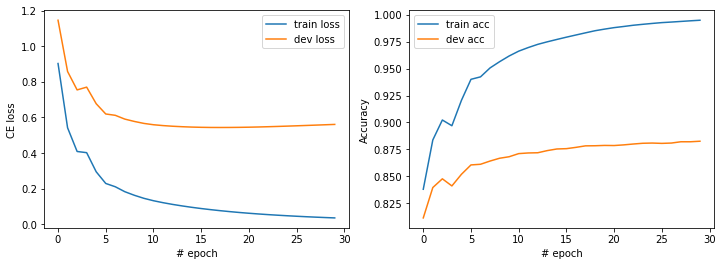

In [9]:
xs = np.arange(num_epochs)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 4))
ax0, ax1 = axes.ravel()
ax0.plot(xs, tr_loss, label='train loss')
ax0.plot(xs, dev_loss, label='dev loss')
ax0.legend()
ax0.set_xlabel('# epoch')
ax0.set_ylabel('CE loss')
ax1.plot(xs, tr_metric, label='train acc')
ax1.plot(xs, dev_metric, label='dev acc')
ax1.legend()
ax1.set_xlabel('# epoch')
ax1.set_ylabel('Accuracy')
plt.show()


Finally, we should evaluate the model performance on test data.

In [10]:
def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

accuracy = nn_test(testData, testLabels, params)
print('Test accuracy: {0}'.format(accuracy))


Test accuracy: 0.882


## Part 2: Adversarial Examples for Neural Networks

It has been seen that many classifiers, including neural networks, are highly susceptible to what are called adversarial examples -- small perturbations of the input that cause a classifier to misclassify, but are imperceptible to humans. For example, making a small change to an image of a stop sign might cause an object detector in an autonomous vehicle to classify it as an yield sign, which could lead to an accident.

In this part, we will see **how to construct adversarial examples for neural networks**, and you are given a 3-hidden layer perceptron trained on the MNIST dataset for this purpose.

Since we are interested in constructing the countersample rather than the original classification task, we do not need to worry too much about the design of the neural network and the processing of the data (which are already given). The parameters of the perceptron can be loaded from fc\*.weight,npy and fc\*.bias.npy. The test dataset can be loaded from X_test.npy and Y_test.npy. Each image of MNIST is 28×28 pixels in size, and is generally represented as a flat vector of 784 numbers. It also includes labels for each example, a number indicating the actual digit (0 - 9) handwritten in that image. 

**Enjoy practicing generating adversarial examples and have fun!**




In [11]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

First, we need to define some functions for later computing.

(a) **[10 points]** Please realize the following functions: 

relu: The relu function is calculated as:

$$
relu(x)=max(0,x)
$$

relu_grad: The relu_grad is used to compute the gradient of relu function as:

$$
relu\_grad(x)=(1(x>0),0(x \leq 0))
$$

one_hot: In the implementation of the cross entropy loss, it is much convenient if numerical labels are transformed into one-hot labels. For example, numerical label 6 -> one-hot label [0,0,0,0,0,0,1,0,0,0]. Accordingly, the cross entropy loss can be written as follow:

$$
cross\_entropy(y,\hat y)=-\sum_{k=1}^K y_k \log \hat y_k
$$

where $\hat{y}$ is the softmax outputs from the model for the training example, $y$ is the one-hot (ground-truth) label, and the subscript refers to the element of $y$ at the coordinate $k$. 


In [12]:
def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        relu_x: a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    ### YOUR CODE HERE
    relu_x = np.maximum(x, 0)
    ### END YOUR CODE
    return relu_x

def relu_grad(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        relu_grad_x: a vector in ndarray format,
        representing the gradient of ReLu activation.
    '''
    ### YOUR CODE HERE
    x[x<=0]=0
    x[x>0]=1
    relu_grad_x = x
    #print(relu_grad_x)
    ### END YOUR CODE
    return relu_grad_x

def cross_entropy(y, y_hat):
    '''
    Input
        y: an int representing the class label
        y_hat: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(y_hat.squeeze())

    return log_likelihood[y]

Next, we define the structure and some utility functions of our multi-layer perceptron.


The neural net is a fully-connected multi-layer perceptron with three hidden layers. The hidden layers contains 2048, 512 and 512 hidden nodes respectively. We use ReLU as the activation function at each hidden node. The last intermediate layer’s output is passed through a softmax function, and the loss is measured as the cross-entropy between the resulted probability vector and the true label.


    x: the input image vector with dimension 1x784.
    y: the true class label of x.
    zi: the value of the i-th intermediate layer before activation, with dimension 1x2048, 1x512, 1x512 and 1x10 for i = 1, 2, 3, 4.
    hi: the value of the i-th intermediate layer after activation, with dimension 1x2048, 1x512 and 1x512 for i = 1, 2, 3.
    p: the predicted class probability vector after the softmax function, with dimension 1x10.
    Wi: the weights between the (i - 1)-th and the i-th intermediate layer. For simplicity, we use h0 as an alias to x. Each Wi has dimension li_1 x li, where li is the number of nodes in the i-th layer. For example, W1 ha dimension 784x2048.
    bi: the bias between the (i - 1)-th and the i-th intermediate layer. The dimension is 1 x li.

(b) **[20 points]** Please realize the forward propogation and the gradient calculation:

**[10 points]** The forward propagation rules are as follows.
$$
z^i = h^{i-1} \cdot W^i + b^i, i = 1, 2, 3, 4.
$$

$$
z^i = h^{i-1} \cdot W^i + b^i, i = 1, 2, 3.
$$

$$
p = Softmax(z^4)
$$

**[10 points]** The gradient calculation rules are as follows.

Let L denote the cross entropy loss of an image-label pair (x, y). We are interested in the gradient of L w.r.t. x, and move x in the direction of (the sign of) the gradient to increase L. If L becomes large, the new image x_adv will likely be misclassified.

We use chain rule for gradient computation. Again, let h0 be the alias of x. We have:
$$
\frac{\delta L}{\delta x} =  \frac{\delta L}{\delta z^4} \frac{\delta z^4}{\delta h^3} \prod_{i=1}^{3} \{ \frac{\delta h^i}{\delta z^i} \frac{\delta z^i}{\delta h^{i-1}} \}
$$

The intermediate terms can be computed as follows.

$$
\frac{\delta L}{z^4} = p - one\_hot(y)
$$

$$
\frac{z^i}{h^{i-1}} = (W^i)^T
$$

$$
\frac{\delta h^i}{\delta z^i}=relu\_grad(z^i)
$$

(c) **[10 points]** Please generate the adversarial examples based on the gradient.

We begin with deriving a simple way of constructing an adversarial example around an input (x, y).
Supppose we denote our neural network by a function f: X $\rightarrow$ {0,...,9}.
Suppose we want to find a small perturbation $\Delta$ of x such that the neural network f assigns a label different from y to x+$\Delta$. To find such a $\Delta$, we want to increase the cross-entropy loss of the network f at (x, y); in other words, we want to take a small step $\Delta$ along which the cross-entropy loss increases, thus causing a misclassification. We can write this as a gradient ascent update, and to ensure that we only take a small step, we can just use the sign of each coordinate of the gradient. The final algorithm is this:

$$
x_{adv} = x + \epsilon \cdot sign (\nabla L(f(x), y))
$$

where L is the cross-entropy loss, and it is known as the **Fast Gradient Sign Method (FGSM)**.



In [13]:
class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
    
    def load_params(self, params):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            self.p: a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        
        self.z1 = np.matmul(x,W1)+b1
        #######################################
        ### YOUR CODE HERE
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        ### END YOUR CODE
        #######################################

        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)


    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            grad: a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        
        #######################################
        ### YOUR CODE HERE
        L = cross_entropy(y, self.forward(x))

        delta_L_z4 = self.forward(x)-one_hot_labels(y)
        delta_z4_h3 = self.W4.T
        delta_h3_z3 = relu_grad(self.z3)
        delta_z3_h2 = self.W3.T
        delta_h2_z2 = relu_grad(self.z2)
        delta_z2_h1 = self.W2.T
        delta_h1_z1 = relu_grad(self.z1)
        delta_z1_h0 = self.W1.T
        inter1 = np.dot(delta_L_z4, delta_z4_h3)
        inter2 = np.multiply(inter1, delta_h3_z3)
        inter3 = np.dot(inter2, delta_z3_h2)
        inter4 = np.multiply(inter3, delta_h2_z2)
        inter5 = np.dot(inter4, delta_z2_h1)
        inter6 = np.multiply(inter5, delta_h1_z1)
        inter7 = np.dot(inter6, delta_z1_h0)
        grad = inter7
        
        ### END YOUR CODE
        #######################################
        
        return grad
    
    def attack(self,x,y):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            x_adv: a vector in ndarray format, representing
            the adversarial example created from image X_test.npy.
        '''
        
        #######################################
        ### YOUR CODE HERE
        x_adv = x + self.eps * np.sign(self.gradient(x, y))


        ### END YOUR CODE
        #######################################
        
        return x_adv

Now, let's load the test data and the pre-trained model.

In [14]:
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)

Check if the image data are loaded correctly. Let's visualize the first image in the data set.

This is an image of Number 7


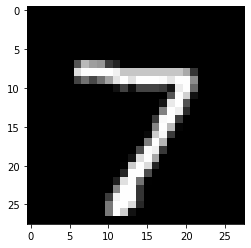

In [15]:
x, y = X_test[0], Y_test[0]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

Check if the model is loaded correctly. The test accuracy may be 97.6%

In [16]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    Y_pred[i] = clf.predict(x[None,:])
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.976


(d) **[5 points]** Please generate an adversarial example and check the image. 

This is an adversarial image of Number 7


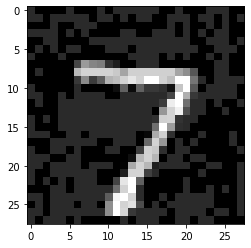

In [17]:
### Output pixels: the adversarial example.
### YOUR CODE HERE
x, y = X_test[0], Y_test[0]
x_adv = clf.attack(x[None,:], y)
print ("This is an adversarial image of Number", y)
pixels = x_adv.reshape((28,28))
### END YOUR CODE
plt.imshow(pixels,cmap="gray")



(e) **[5 points]** Try the adversarial attack and test the accuracy of using adversarial examples.

You can get a test accuracy of using adversarial examples after running this cell.

In [18]:
### Output acc: the adversarial accuracy.
### YOUR CODE HERE
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    x_adv = clf.attack(x[None,:], y)
    Y_pred[i] = clf.predict(x_adv)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
### END YOUR CODE
print ("Test accuracy of adversarial examples is", acc)



Test accuracy of adversarial examples is 0.014
